Epoch 0: Loss = 0.6928
Epoch 10: Loss = 0.6928
Epoch 20: Loss = 0.6927
Epoch 30: Loss = 0.6927
Epoch 40: Loss = 0.6927
Epoch 50: Loss = 0.6926
Epoch 60: Loss = 0.6926
Epoch 70: Loss = 0.6926
Epoch 80: Loss = 0.6926
Epoch 90: Loss = 0.6925
Epoch 100: Loss = 0.6925
Epoch 110: Loss = 0.6925
Epoch 120: Loss = 0.6925
Epoch 130: Loss = 0.6925
Epoch 140: Loss = 0.6924
Epoch 150: Loss = 0.6924
Epoch 160: Loss = 0.6924
Epoch 170: Loss = 0.6924
Epoch 180: Loss = 0.6923
Epoch 190: Loss = 0.6923
Epoch 200: Loss = 0.6923
Epoch 210: Loss = 0.6923
Epoch 220: Loss = 0.6922
Epoch 230: Loss = 0.6922
Epoch 240: Loss = 0.6922
Epoch 250: Loss = 0.6922
Epoch 260: Loss = 0.6922
Epoch 270: Loss = 0.6921
Epoch 280: Loss = 0.6921
Epoch 290: Loss = 0.6921
Epoch 300: Loss = 0.6921
Epoch 310: Loss = 0.6920
Epoch 320: Loss = 0.6920
Epoch 330: Loss = 0.6920
Epoch 340: Loss = 0.6920
Epoch 350: Loss = 0.6920
Epoch 360: Loss = 0.6919
Epoch 370: Loss = 0.6919
Epoch 380: Loss = 0.6919
Epoch 390: Loss = 0.6919
Epoch 400: 

C:\Users\berin\PycharmProjects\Lab7\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\berin\PycharmProjects\Lab7\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\berin\PycharmProjects\Lab7\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

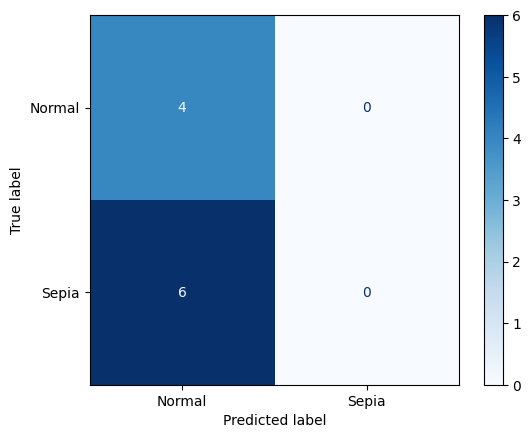

In [47]:
import numpy as np
from PIL import Image
import os
import io
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class SimpleCNN:
    def __init__(self, input_shape, num_filters=12, filter_size=6, num_classes=2):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.num_classes = num_classes

        self.filters = np.random.randn(num_filters, filter_size, filter_size, input_shape[2]) * 0.01
        conv_output_size = input_shape[0] - filter_size + 1
        self.flatten_size = conv_output_size * conv_output_size * num_filters
        self.weights = np.random.randn(self.flatten_size, num_classes) * 0.01
        self.bias = np.zeros((1, num_classes))

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def convolve(self, img, conv_filter):
        h, w, c = img.shape
        fh, fw, _ = conv_filter.shape
        out = np.zeros((h - fh + 1, w - fw + 1))
        for i in range(out.shape[0]):
            for j in range(out.shape[1]):
                region = img[i:i+fh, j:j+fw, :]
                out[i, j] = np.sum(region * conv_filter)
        return out

    def forward(self, X):
        batch_size = X.shape[0]
        conv_outs = []
        for img in X:
            conv_maps = [self.relu(self.convolve(img, f)) for f in self.filters]
            stacked = np.stack(conv_maps, axis=-1)
            conv_outs.append(stacked)
        conv_outs = np.array(conv_outs)
        flat = conv_outs.reshape(batch_size, -1)
        logits = flat @ self.weights + self.bias
        return self.softmax(logits)

    def predict(self, X):
        probs = self.forward(X)
        return ["Normal" if np.argmax(p) == 0 else "Sepia" for p in probs]

    def one_hot(self, y):
        return np.array([[1, 0] if label == "Normal" else [0, 1] for label in y])

    def compute_loss(self, probs, labels_onehot):
        return -np.mean(np.sum(labels_onehot * np.log(probs + 1e-8), axis=1))

    def fit(self, X, y, epochs=100, lr=0.01):
        y_encoded = self.one_hot(y)
        for epoch in range(epochs):
            probs = self.forward(X)
            loss = self.compute_loss(probs, y_encoded)

            # Forward again to get flattened conv output
            conv_outs = []
            for img in X:
                conv_maps = [self.relu(self.convolve(img, f)) for f in self.filters]
                stacked = np.stack(conv_maps, axis=-1)
                conv_outs.append(stacked)
            conv_outs = np.array(conv_outs)
            flat = conv_outs.reshape(X.shape[0], -1)

            d_logits = probs - y_encoded
            dW = flat.T @ d_logits / X.shape[0]
            db = np.sum(d_logits, axis=0, keepdims=True) / X.shape[0]

            self.weights -= lr * dW
            self.bias -= lr * db

            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")

def loadData():
    currentPath = os.path.join(os.getcwd(), "Photos")
    inputs, outputs = [], []
    for file in os.listdir(currentPath):
        label = "Normal" if "person" in file else "Sepia"
        file_path = os.path.join(currentPath, file)
        with open(file_path, "rb") as f:
            img = Image.open(io.BytesIO(f.read())).convert("RGB")
            inputs.append(img)
            outputs.append(label)
    return inputs, outputs

def resize_images(images, target_size=(32, 32)):
    return np.array([np.array(img.resize(target_size)) / 255.0 for img in images])

def splitData(inputs, outputs):
    np.random.seed(5)
    indexes = np.arange(len(inputs))
    np.random.shuffle(indexes)
    split = int(0.8 * len(inputs))
    train_idx, test_idx = indexes[:split], indexes[split:]
    return [inputs[i] for i in train_idx], [outputs[i] for i in train_idx], [inputs[i] for i in test_idx], [outputs[i] for i in test_idx]

# === Main logic ===
inputs, outputs = loadData()
inputs_resized = resize_images(inputs, (8, 8))
trainX, trainY, testX, testY = splitData(inputs_resized, outputs)

X_train = np.array(trainX)
X_test = np.array(testX)

model = SimpleCNN(input_shape=(8, 8, 3))
model.fit(X_train, trainY, epochs=3000, lr=0.001)

predictions = model.predict(X_test)

print("Predictions:", predictions)
print("Actual:     ", testY)
print("Accuracy:   ", accuracy_score(testY, predictions))
print("Classification Report:\n", classification_report(testY, predictions))

cm = confusion_matrix(testY, predictions, labels=["Normal", "Sepia"])
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Sepia"]).plot(cmap='Blues')
plt.show()
